## Завдання

Напишіть Python-скрипт, який завантажує текст із заданої URL-адреси, аналізує частоту використання слів у тексті за допомогою парадигми MapReduce і візуалізує топ-слова з найвищою частотою використання у тексті.

**Покрокова інструкція**

1. Імпортуйте необхідні модулі (`matplotlib` та інші).

2. Візьміть код реалізації MapReduce з конспекту.

3. Створіть функцію `visualize_top_words` для візуалізації результатів.

4. У головному блоці коду отримайте текст за URL, застосуйте MapReduce та візуалізуйте результати.


**Критерії прийняття**

     📌Критерії прийняття домашнього завдання є обов’язковою умовою розгляду завдання ментором. Якщо якийсь з критеріїв не виконано, ДЗ відправляється ментором на доопрацювання без оцінювання. Якщо вам «тільки уточнити»😉 або ви «застопорилися» на якомусь з етапів виконання — звертайтеся до ментора у Slack).

1. Код успішно завантажує текст із заданої URL-адреси.

2. Код коректно виконує аналіз частоти слів із використанням MapReduce.

3. Візуалізація відображає топ-слова за частотою використання.

4. Код ефективно використовує багатопотоковість.

5. Код читабельний та відповідає стандартам PEP 8.

## Рішення

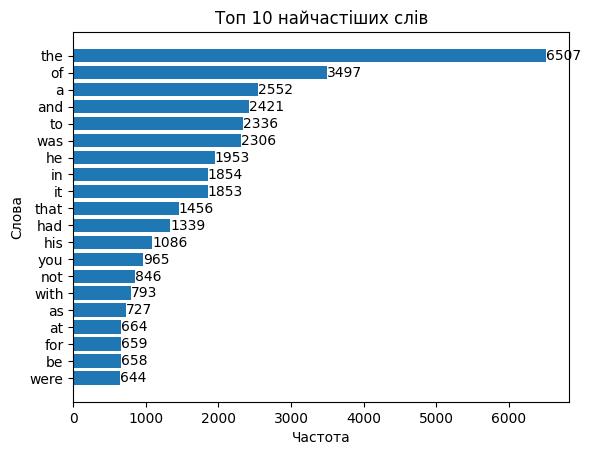

In [9]:
import string

from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

import requests
from pprint import pprint


def get_text(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Перевірка на помилки HTTP
        return response.text
    except requests.RequestException as e:
        return None


# Функція для видалення знаків пунктуації
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))


def map_function(word):
    return word, 1


def shuffle_function(mapped_values):
    shuffled = defaultdict(list)
    for key, value in mapped_values:
        shuffled[key].append(value)
    return shuffled.items()


def reduce_function(key_values):
    key, values = key_values
    return key, sum(values)


# Виконання MapReduce
def map_reduce(text, search_words=None):
    # Видалення знаків пунктуації
    text = remove_punctuation(text)
    words = text.lower().split()

    # Якщо задано список слів для пошуку, враховувати тільки ці слова
    if search_words:
        words = [word for word in words if word in search_words]

    # Паралельний Мапінг
    with ThreadPoolExecutor() as executor:
        mapped_values = list(executor.map(map_function, words))

    # Крок 2: Shuffle
    shuffled_values = shuffle_function(mapped_values)

    # Паралельна Редукція
    with ThreadPoolExecutor() as executor:
        reduced_values = list(executor.map(reduce_function, shuffled_values))

    return dict(reduced_values)


# Отримати топ слів
def get_top_words(result, top=10):
    return sorted(result.items(), key=lambda x: x[1], reverse=True)[:top]

# Виведення результатів у вигляді горизонтальної гістограми на plt
def plot_horizontal_bar(word_freq_list):
    import matplotlib.pyplot as plt

    words, freq = zip(*word_freq_list[::-1])

    plt.barh(words, freq)
    plt.xlabel('Частота')
    plt.ylabel('Слова')
    plt.title('Топ 10 найчастіших слів')
    # Додавання підписів значень
    for index, value in enumerate(freq):
        plt.text(value, index, str(value), va='center')
    plt.show()


# Візуалізація результатів
def visualize_top_words(list_of_words, top=10):

    sorted_words = get_top_words(list_of_words, top)

    # Малюємо гістограму
    plot_horizontal_bar(sorted_words)

if __name__ == "__main__":
    # Вхідний текст для обробки
    url = "https://gutenberg.net.au/ebooks01/0100021.txt"
    # text = get_text(url)
    if text:
        # Можна задати слова для пошуку
        search_words = []
        # search_words = ["war", "peace", "love", "hate", "death", "life", "101"]
        
        # Виконання MapReduce на вхідному тексті
        result = map_reduce(text, search_words)
        
        # Виведення результатів
        visualize_top_words(result, 20)
    else:
        print("Помилка: Не вдалося отримати вхідний текст.")